In [1]:
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt
import numpy as np
import svgpathtools

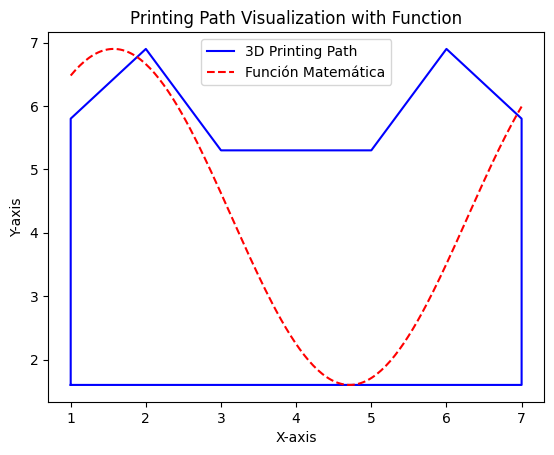

In [6]:
def load_svg():
    file_path = "./models/casa.svg"
    paths, _ = svgpathtools.svg2paths(file_path)
    process_svg(paths)

def process_svg(paths):
    trajectory = []
    for path in paths:
        for segment in path:
            points = np.linspace(0, 1, 100)
            for point in points:
                pos = segment.point(point)
                trajectory.append((pos.real, pos.imag))
    plot_trajectory(trajectory)

def plot_trajectory(trajectory):
    x, y = zip(*trajectory)
    plt.figure()
    
    # Dibujar la trayectoria del SVG
    plt.plot(x, y, label='3D Printing Path', color='blue')

    # Definir una función matemática para superponerla
    x_func = np.linspace(min(x), max(x), 200)
    y_func = np.sin(x_func) * (max(y) - min(y)) / 2 + (max(y) + min(y)) / 2  # Ejemplo: una onda sinusoidal
    
    # Dibujar la función matemática en la misma figura
    plt.plot(x_func, y_func, label='Función Matemática', color='red', linestyle='--')

    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Printing Path Visualization with Function')
    plt.legend()
    plt.show()

def start_ui():
    root = tk.Tk()
    root.title("3D Printer Configuration")
    
    tk.Label(root, text="Resolución de Impresión (mm)").pack()
    resolution_entry = tk.Entry(root)
    resolution_entry.pack()

    tk.Label(root, text="Velocidad de Impresión (mm/s)").pack()
    speed_entry = tk.Entry(root)
    speed_entry.pack()

    load_button = tk.Button(root, text="Cargar Archivo SVG", command=load_svg)
    load_button.pack()

    root.mainloop()

if __name__ == "__main__":
    start_ui()

In [ ]:
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt
import numpy as np
import svgpathtools

In [4]:


def load_svg():
    file_path = filedialog.askopenfilename(filetypes=[("SVG files", "*.svg")])
    if file_path:
        paths, _ = svgpathtools.svg2paths(file_path)
        process_svg(paths)

def process_svg(paths):
    trajectory = []
    for path in paths:
        for segment in path:
            points = np.linspace(0, 1, 100)
            for point in points:
                pos = segment.point(point)
                trajectory.append((pos.real, pos.imag))
    plot_trajectory(trajectory)

def plot_trajectory(trajectory):
    x, y = zip(*trajectory)
    plt.figure()
    plt.plot(x, y, label='3D Printing Path')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Printing Path Visualization')
    plt.legend()
    plt.show()

def start_ui():
    root = tk.Tk()
    root.title("3D Printer Configuration")
    
    tk.Label(root, text="Resolución de Impresión (mm)").pack()
    resolution_entry = tk.Entry(root)
    resolution_entry.pack()

    tk.Label(root, text="Velocidad de Impresión (mm/s)").pack()
    speed_entry = tk.Entry(root)
    speed_entry.pack()

    load_button = tk.Button(root, text="Cargar Archivo SVG", command=load_svg)
    load_button.pack()

    root.mainloop()

if __name__ == "__main__":
    start_ui()
